In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Sun May 15 19:08:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 36%   46C    P8    39W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 31%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    db_de = db.patent_de
    db_us = db.patent_us
    db_cn = db.patent_cn
    db_rm_cn_5 = db.rm_patent_cn_5
    db_rm_cn_10 = db.rm_patent_cn_10
    db_rm_us_5 = db.rm_patent_us_5
    db_rm_us_10 = db.rm_patent_us_10
    db_rm_de_5 = db.rm_patent_de_5
    db_rm_de_10 = db.rm_patent_de_10
    
except errors.ConnectionFailure as err:
    print(err)

# 前五年

## Company數量

In [6]:
data_assignee = db_rm_de_5.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [7]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
data_assignee = db_rm_cn_5.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_rm_us_5.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [11]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
65,Samsung Electronics Co Ltd,395
34,Intel Corp,339
40,Jiangsu IoT Research and Development Center,295
14,Cisco Technology Inc,210
52,Nanjing IoT Sensor Technology Co Ltd,203
58,Qualcomm Inc,176
70,Telefonaktiebolaget LM Ericsson AB,144
11,Chengdu Qinchuan IoT Technology Co Ltd,140
64,SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,82
45,LG Electronics Inc,69


In [12]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

In [13]:
com_df.reset_index(drop=True, inplace=True)

In [14]:
# com_ls = list(final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)["company"])
# com_ls

['Qualcomm Inc',
 'Samsung Electronics Co Ltd',
 'Intel Corp',
 'Telefonaktiebolaget LM Ericsson AB',
 'Huawei Technologies Co Ltd',
 'LG Electronics Inc',
 'International Business Machines Corp',
 'Apple Inc',
 'Cisco Technology Inc',
 'Microsoft Technology Licensing LLC',
 'Micron Technology Inc',
 'Sony Corp',
 'Nokia Technologies Oy',
 'Shenzhen Shenglu IoT Communication Technology Co Ltd',
 'NTT Docomo Inc']

In [15]:
# com_ls=['Qualcomm Inc', 'Samsung Electronics Co Ltd', 'Intel Corp', 'Telefonaktiebolaget LM Ericsson AB', 'Huawei Technologies Co Ltd', 'LG Electronics Inc', 'International Business Machines Corp', 'Apple Inc', 'Cisco Technology Inc', 'Microsoft Technology Licensing LLC', 'Micron Technology Inc', 'Sony Corp', 'Nokia Technologies Oy', 'Shenzhen Shenglu IoT Communication Technology Co Ltd', 'NTT Docomo Inc']

In [16]:
# com_count = [8491,6337,3236,2488,2461,1931,1591,1104,1092,963,731,711,668,656,612]

In [17]:
# com_df = pd.DataFrame((zip(com_ls, com_count)), columns = ['company', 'count'])

In [18]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))

In [19]:
com_df

,company,count,count_log
0,Samsung Electronics Co Ltd,395,5.978886
1,Intel Corp,339,5.826000
2,Jiangsu IoT Research and Development Center,295,5.686975
3,Cisco Technology Inc,210,5.347108
4,Nanjing IoT Sensor Technology Co Ltd,203,5.313206
5,Qualcomm Inc,176,5.170484
6,Telefonaktiebolaget LM Ericsson AB,144,4.969813
7,Chengdu Qinchuan IoT Technology Co Ltd,140,4.941642
8,SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,82,4.406719
9,LG Electronics Inc,69,4.234107


In [20]:
com_ls = list(com_df.company)

## Data

In [22]:
ccontry = pd.read_csv("./final_data/rm_company_country_all_5.csv")

In [23]:
ccpc = pd.read_csv("./final_data/rm_company_cpc_all_5.csv")

In [24]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AP,AR,AT,AU,BR,CA,CH,CL,CN,...,SI,SM,TN,TR,TW,UA,US,UY,WO,ZA
352,Chengdu Qinchuan IoT Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0
429,China core Microelectronics Technology Chengdu...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
458,Cisco Technology Inc,0.0,0.0,0.0,2.0,0.0,13.0,0.0,0.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,213.0,0.0,75.0,0.0
473,Convida Wireless LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,...,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,55.0,0.0
989,Intel Corp,0.0,0.0,0.0,0.0,20.0,1.0,0.0,0.0,166.0,...,0.0,0.0,0.0,0.0,66.0,0.0,380.0,0.0,260.0,0.0


## Similarity計算

### Country

- 換成機率  

In [25]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [26]:
P = ccontry2[ccontry2.index==com_ls[0]].values.tolist()[0][1:]
Q = ccontry2[ccontry2.index==com_ls[1]].values.tolist()[0][1:]

In [27]:
# print(P)
# print(Q)

### PBC
- 和Samsung Electronics Co Ltd比較

In [28]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc

,AP,AR,AT,AU,BR,CA,CH,CL,CN,CO,...,SI,SM,TN,TR,TW,UA,US,UY,WO,ZA
company,,,,,,,,,,,,,,,,,,,,,
Samsung Electronics Co Ltd,0.0,0.000000,0.0,0.007513,0.000000,0.002254,0.0,0.0,0.138242,0.0,...,0.0,0.0,0.0,0.0,0.011270,0.0,0.302780,0.0,0.126972,0.00
Intel Corp,0.0,0.000000,0.0,0.000000,0.016598,0.000830,0.0,0.0,0.137759,0.0,...,0.0,0.0,0.0,0.0,0.054772,0.0,0.315353,0.0,0.215768,0.00
Jiangsu IoT Research and Development Center,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.978495,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.021505,0.00
Cisco Technology Inc,0.0,0.000000,0.0,0.004914,0.000000,0.031941,0.0,0.0,0.049140,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.523342,0.0,0.184275,0.00
Nanjing IoT Sensor Technology Co Ltd,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00
Qualcomm Inc,0.0,0.000000,0.0,0.003067,0.023517,0.004090,0.0,0.0,0.144172,0.0,...,0.0,0.0,0.0,0.0,0.038855,0.0,0.193252,0.0,0.183027,0.00
Telefonaktiebolaget LM Ericsson AB,0.0,0.008333,0.0,0.003333,0.016667,0.008333,0.0,0.0,0.108333,0.0,...,0.0,0.0,0.0,0.0,0.008333,0.0,0.253333,0.0,0.248333,0.01
Chengdu Qinchuan IoT Technology Co Ltd,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.881988,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.031056,0.0,0.031056,0.00
SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00


In [29]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

###### n

In [30]:
pbc_ls=[]
n=0.05

for i in ccontry_pbc.index:
    pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
    pbc_ls.append(pbc[0])
    
ccontry_pbc["pbc"]=pbc_ls

In [31]:
# ccontry_pbc.sort_values(["pbc"],ascending=True)

### CPC

In [32]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [33]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [34]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

###### n

In [35]:
pbc_ls=[]
n=0.06

for i in ccpc_pbc.index:
    pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
    pbc_ls.append(pbc[0])
    
ccpc_pbc["pbc"]=pbc_ls

In [36]:
ccpc_pbc.sort_values(["pbc"],ascending=True)

,A01,A23,A41,A42,A43,A44,A45,A46,A47,A61,...,H01,H02,H03,H04,H05,Y02,Y04,Y10,sum,pbc
company,,,,,,,,,,,,,,,,,,,,,
Jiangsu IoT Research and Development Center,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.049020,...,0.617647,0.003268,0.000000,0.120915,0.000000,0.049020,0.000000,0.000000,0.135465,0.140578
Nanjing IoT Sensor Technology Co Ltd,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.186047,0.023256,0.418605,0.046512,0.000000,0.120507,0.147095
SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,0.041667,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.041667,0.000000,0.000000,0.020833,0.104167,0.104167,0.000000,0.000000,0.032243,0.180545
Chengdu Qinchuan IoT Technology Co Ltd,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.100000,0.000000,0.254545,0.000000,0.163636,0.054545,0.000000,0.152870,0.217423
"China core Microelectronics Technology Chengdu Co.,Ltd.",0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019989,0.222188
Intel Corp,0.001849,0.0,0.000616,0.0,0.0,0.0,0.000000,0.000616,0.001541,0.012327,...,0.110940,0.017565,0.008012,0.539599,0.003082,0.024345,0.000924,0.000616,0.337795,0.339197
Samsung Electronics Co Ltd,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000274,0.000000,0.000548,0.014786,...,0.072563,0.010131,0.006846,0.544633,0.016429,0.019441,0.000548,0.001643,0.342459,0.342459
International Business Machines Corp,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.007317,0.021951,...,0.209756,0.000000,0.000000,0.346341,0.007317,0.000000,0.002439,0.000000,0.270444,0.483534
Microsoft Technology Licensing LLC,0.000000,0.0,0.004090,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.004090,...,0.042945,0.028630,0.000000,0.341513,0.008180,0.018405,0.006135,0.000000,0.267364,0.492211


## Scatter Plot

In [37]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

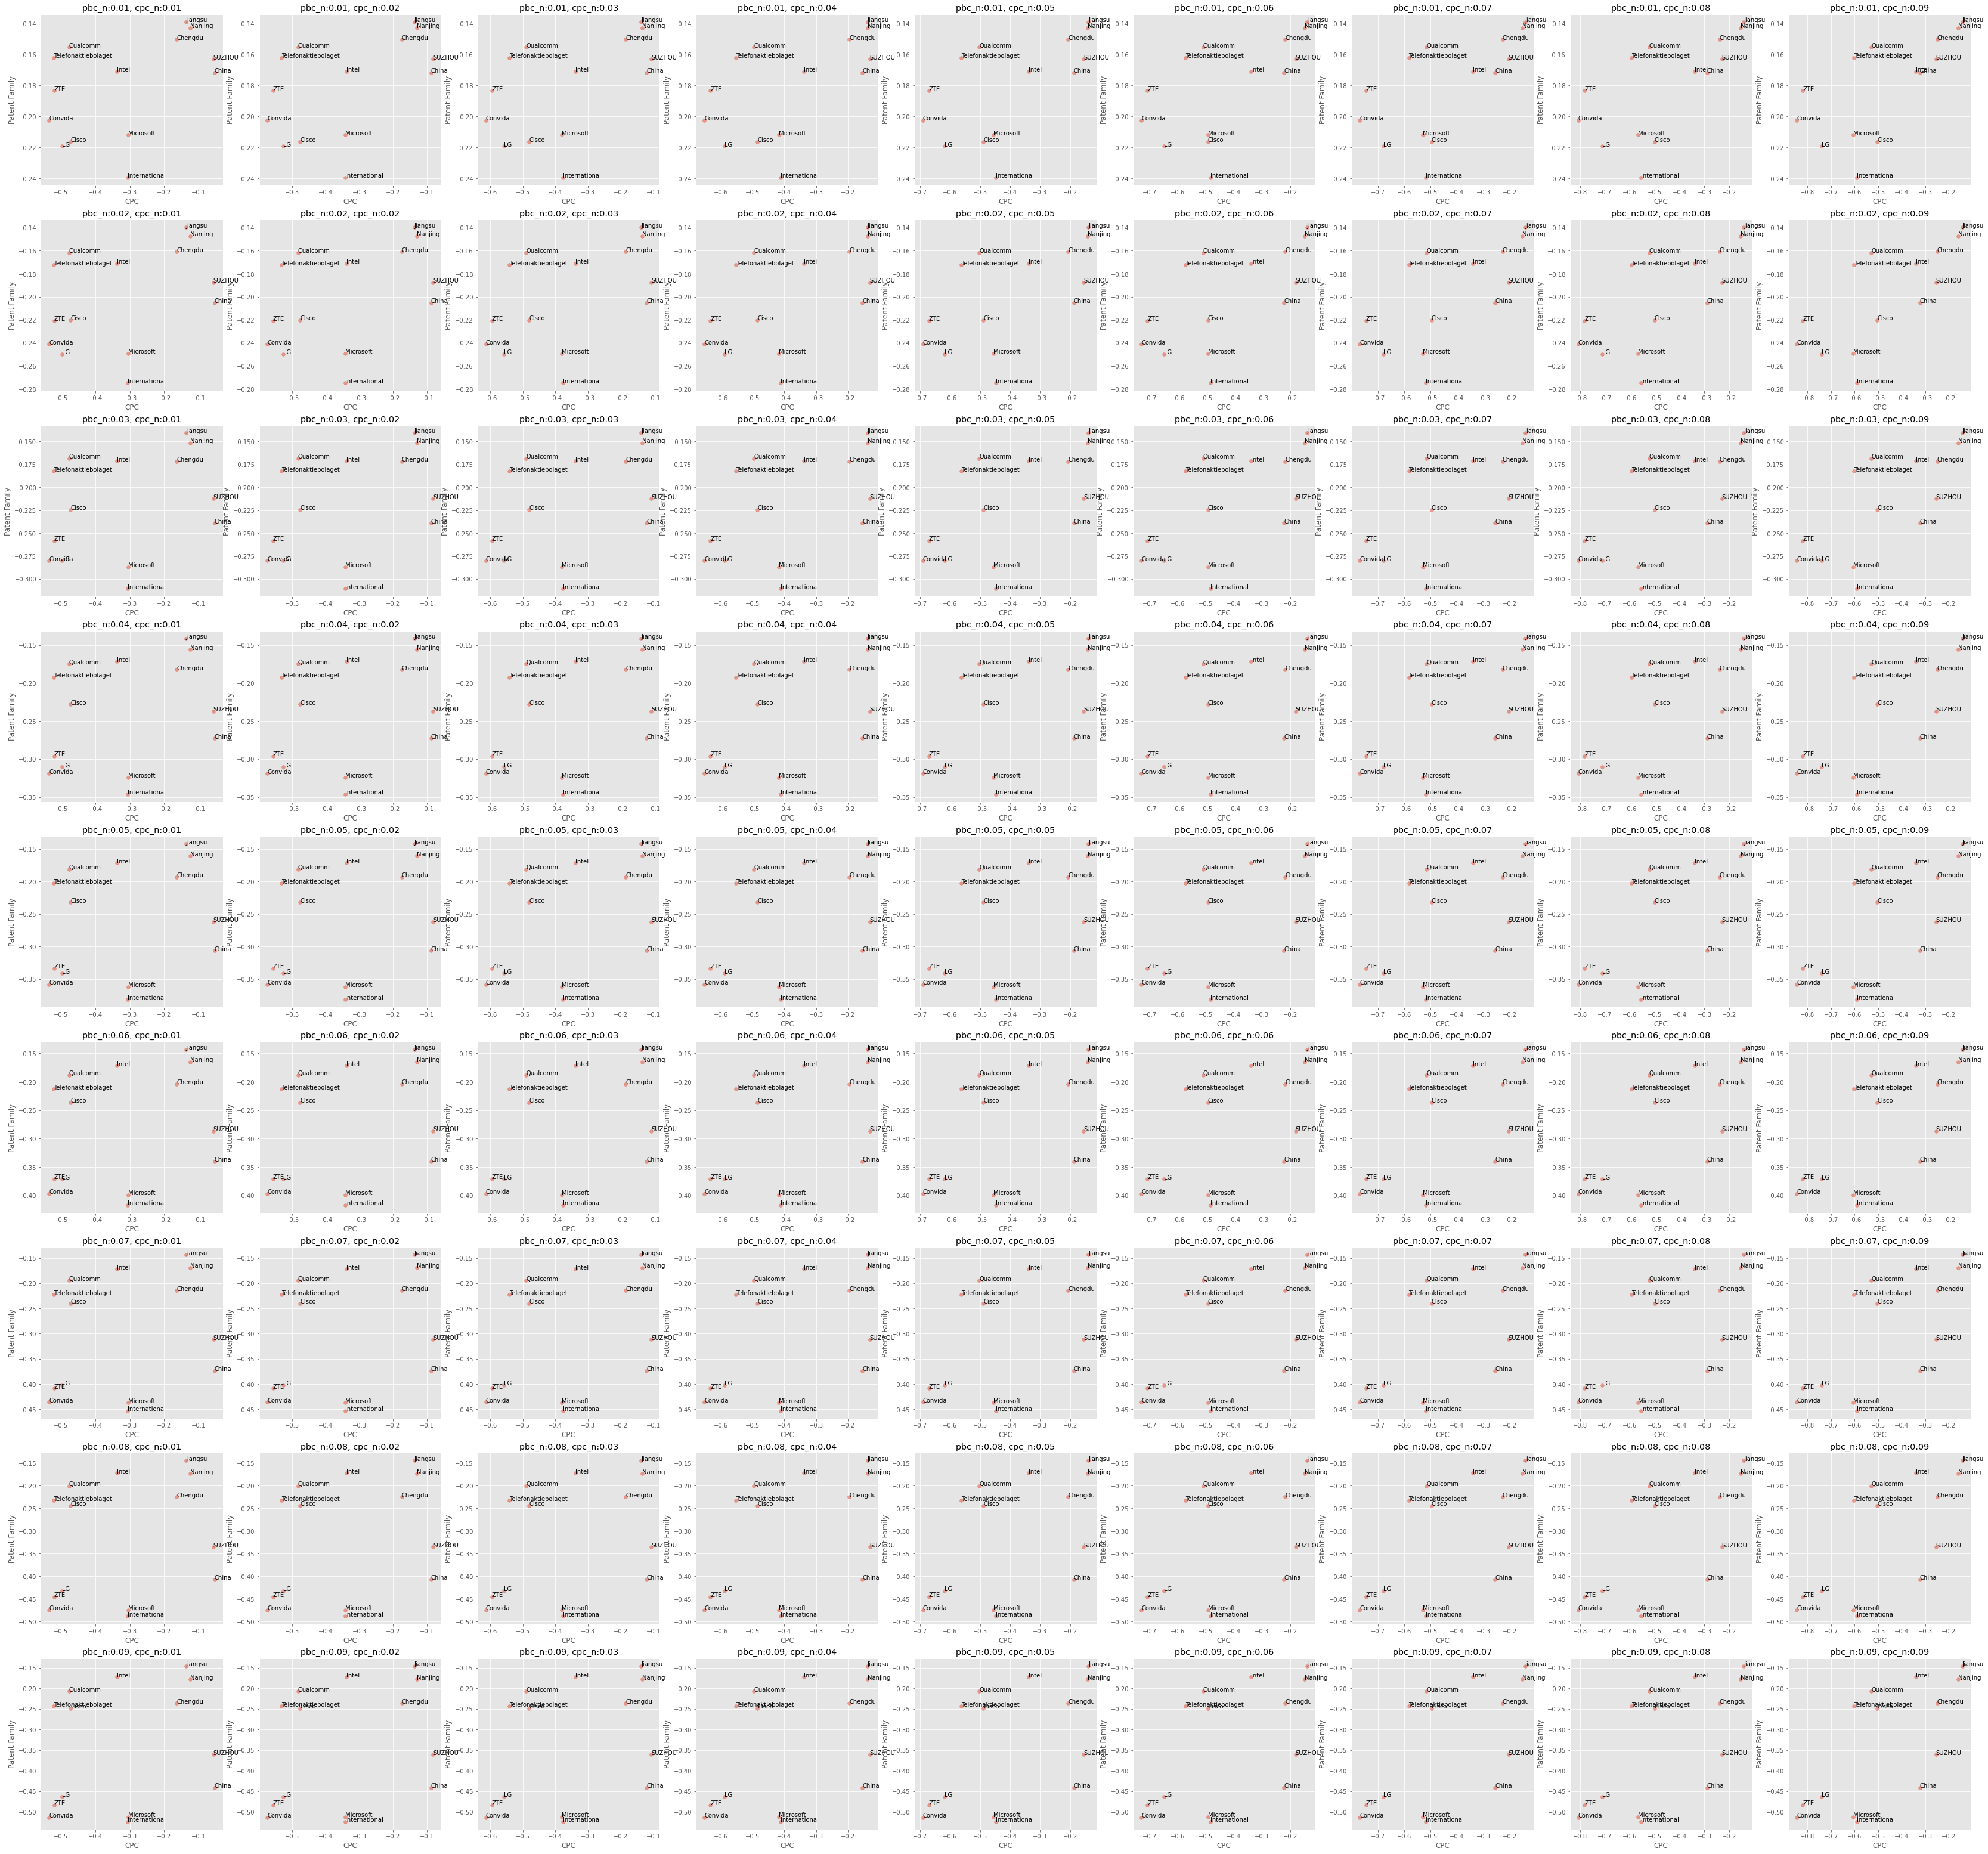

In [40]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/years/plot_all_5_2.png'.format(pbc_n))

In [41]:
c_df

,cpc,country
company,,
Intel Corp,0.339899,0.172722
Jiangsu IoT Research and Development Center,0.143134,0.145669
Cisco Technology Inc,0.504330,0.248255
Nanjing IoT Sensor Technology Co Ltd,0.160389,0.178124
Qualcomm Inc,0.528782,0.207534
Telefonaktiebolaget LM Ericsson AB,0.602966,0.243456
Chengdu Qinchuan IoT Technology Co Ltd,0.249699,0.236261
SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,0.254696,0.360696
LG Electronics Inc,0.740255,0.462777
